In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
# load plotly
import plotly.graph_objects as go
import plotly.express as px
plt.style.use('ggplot')

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1

%load_ext autoreload
%autoreload 2
%matplotlib inline

def pct_error(actual, forecast):
    return (actual - forecast)/actual

def abs_pct_diff_error(actual, forecast):
    return (actual.pct_change() - forecast.pct_change()).abs()

def pct_diff_error(actual, forecast):
    return (actual.pct_change() - forecast.pct_change())


In [3]:
recessions = pd.read_csv('data/JHDUSRGDPBR.csv')
recessions['DATE'] = pd.to_datetime(recessions['DATE'])

# rename columns
recessions.rename(columns={'DATE': 'DATE', 'JHDUSRGDPBR': 'IN_RECESSION'}, inplace=True)
# add three months
recessions['DATE_END'] = recessions['DATE'] + pd.DateOffset(months=3)
recessions.head()

,DATE,IN_RECESSION,DATE_END
0,1967-10-01,0.0,1968-01-01
1,1968-01-01,0.0,1968-04-01
2,1968-04-01,0.0,1968-07-01
3,1968-07-01,0.0,1968-10-01
4,1968-10-01,0.0,1969-01-01


# NGDP Forecast Analysis

## Forecasts
[Data](https://www.philadelphiafed.org/surveys-and-data/real-time-data-research/median-forecasts).

### How the survey is conducted?

BEA releases first GDP estimate (and components) for the **previous** quarter. The report is released at the end of the **1st month** of each quarter.

When survey is sent the advance report from BEA is included (so the forecasters know the previous quarter estimates).

The deadline for the forecasts is 2nd-3rd week of 2nd month in a quarter.

### Surveys

* `xxx1` -- the "forecast" for the quarter prior to the quarter in which the survey is conducted. The forecasters know the values of the variables for this quarter at the time they submit their projections (e.g. they know the **actual** GDP estimates). **Thus the data in this columns corresponds closely to the BEA's advance estimate**.
* `xxx2` - `xxx6` -- projections for the next five quarters.
* NGDP -- forecasts for the quarterly and annual level of nominal GDP (seasonally adjusted).
* RGDP -- chain-weighted real GDP. 1992-1995, fixed weighted real GDP. <1992, fixed weighted real GNP.

In [4]:
ngdp = pd.read_csv('data/medianLevelNGDP.csv')
# convert comma format string type of NGDP1 to float
ngdp['NGDP1'] = ngdp['NGDP1'].str.replace(',', '').astype(float)
ngdp['NGDP2'] = ngdp['NGDP2'].str.replace(',', '').astype(float)
ngdp['NGDP3'] = ngdp['NGDP3'].str.replace(',', '').astype(float)
ngdp['NGDP4'] = ngdp['NGDP4'].str.replace(',', '').astype(float)
ngdp['NGDP5'] = ngdp['NGDP5'].str.replace(',', '').astype(float)
ngdp['NGDP6'] = ngdp['NGDP6'].str.replace(',', '').astype(float)
# combine int year and quarter to date

ngdp['DATE'] = pd.PeriodIndex(ngdp['YEAR'].astype(str) + '-Q' + ngdp['QUARTER'].astype(str), freq='Q').to_timestamp()
ngdp['ACTUAL'] = ngdp['NGDP1'].shift(-1)
ngdp.head()

,YEAR,QUARTER,NGDP1,NGDP2,NGDP3,NGDP4,NGDP5,NGDP6,NGDPA,NGDPB,DATE,ACTUAL
0,1968,4,871.0,885.0,896.0,909.0,925.0,940.0,NaN,NaN,1968-10-01,888.0
1,1969,1,888.0,901.0,912.0,926.0,942.0,NaN,NaN,NaN,1969-01-01,903.0
2,1969,2,903.0,917.0,930.0,943.0,954.0,NaN,NaN,NaN,1969-04-01,925.0
3,1969,3,925.0,939.0,950.0,962.0,974.0,NaN,NaN,NaN,1969-07-01,943.0
4,1969,4,943.0,954.0,965.0,975.0,990.0,1006.0,NaN,NaN,1969-10-01,953.0


(5000.0, 26000.0)

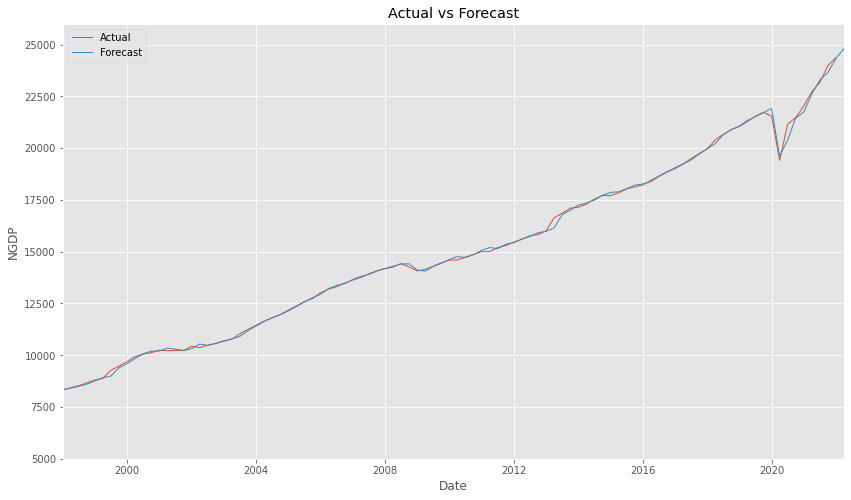

In [5]:
# plot ngdp.ACTUAL vs ngdp.DATE
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(ngdp.DATE, ngdp.ACTUAL, '-', label='Actual')
ax.plot(ngdp.DATE, ngdp.NGDP2, '-', label='Forecast')
ax.legend()
ax.set_title('Actual vs Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('NGDP')
# set x-axis range
ax.set_xlim(pd.Timestamp('1998-01-01'), ngdp.DATE.max())
# set y-axis range
ax.set_ylim(5000, 26000)

No handles with labels found to put in legend.


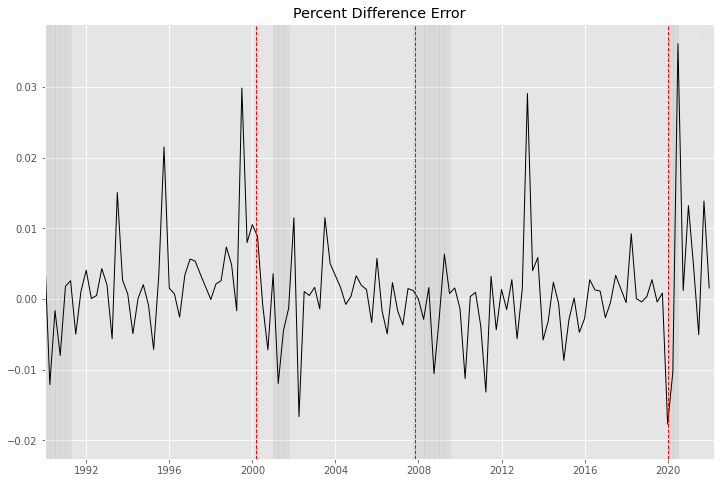

In [6]:
# set figure size
plt.figure(figsize=(12,8))
plt.plot(ngdp.DATE, pct_error(ngdp.ACTUAL, ngdp.NGDP2), color='#000')
plt.title('Percent Difference Error')
plt.xlim(pd.Timestamp('1990-01-01'), ngdp['DATE'].max())

# plot recessions
for r in recessions.itertuples():
    if r.IN_RECESSION:
        plt.axvspan(r.DATE, r.DATE_END, color='grey', alpha=0.1)

# plot stock market crashes
crashes = [
    # dot-com bubble
    pd.Timestamp('2000-03-01'),
    # GFC
    pd.Timestamp('2007-11-01'),
    # Covid
    pd.Timestamp('2020-01-01'),
]
# plot crashes as dashed vertical lines
for c in crashes:
    plt.axvline(c, color='red', linestyle='--')

plt.legend()
plt.show()